# Quick start

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio

from trufl.utils import gridder
from trufl.sampler import Sampler
from trufl.callbacks import (State, MaxCB, MinCB, StdCB, 
                             CountCB, MoranICB, PriorCB)

from trufl.optimizer import Optimizer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
red, black = '#BF360C', '#263238'

### Create a vector grid from a given raster

In [ ]:
fname_raster = '../files/ground-truth-01-4326-simulated.tif'
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)

In [ ]:
gdf_grid.head()

,loc_id,geometry
0,0,"POLYGON ((-1.20830 43.26950, -1.20830 43.26042..."
1,1,"POLYGON ((-1.20830 43.27858, -1.20830 43.26950..."
2,2,"POLYGON ((-1.20830 43.28766, -1.20830 43.27858..."
3,3,"POLYGON ((-1.20830 43.29673, -1.20830 43.28766..."
4,4,"POLYGON ((-1.20830 43.30581, -1.20830 43.29673..."


<Axes: >

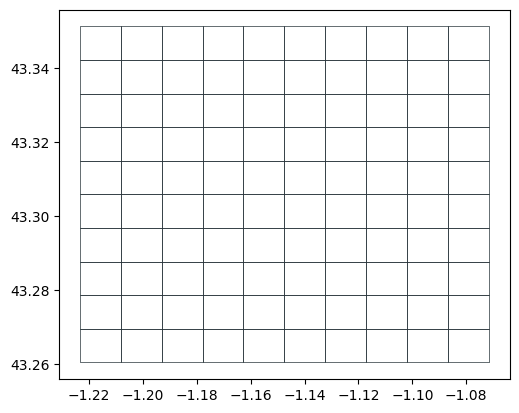

In [ ]:
gdf_grid.boundary.plot(color=black, lw=0.5)

### Emulating data collection

#### Random sample

Generating a random set of points within a given polygon geoseries.

<Axes: >

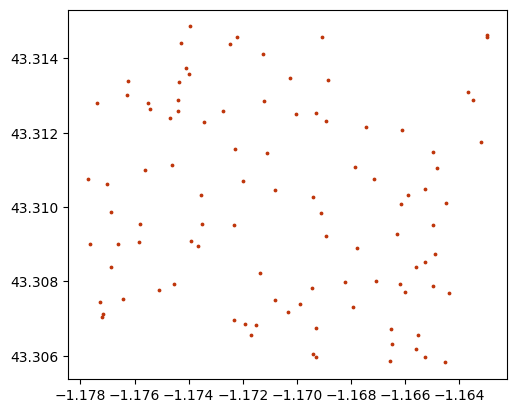

In [ ]:
loc_id = 35
n_pts = 100
sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n_pts)
sampling_locs.plot(markersize=3, color=red)

In [ ]:
sampling_locs

35    MULTIPOINT (-1.17772 43.31077, -1.17765 43.309...
Name: sampled_points, dtype: geometry

#### Emulate data collection

We will simulate a data collection process over a set of areas, which could be administrative units or a gridded version of them. For each area, we will specify the number of measurements to be taken, which we will simulate by generating random numbers between 1 and 100.

For each area, we will follow the following steps:

- **Generate random sample locations**: we will create a set of random coordinates within the bounds of the area, where we will simulate the collection of data.
- **Emulate measurement data**: for each sample location, we will extract the corresponding value from a given raster dataset, which we will use to simulate the actual measurement.

This iterative process will allow us to generate a simulated dataset of measurements, which we can then use for further analysis and modeling.

We will emulate data collection from the raster shown below:

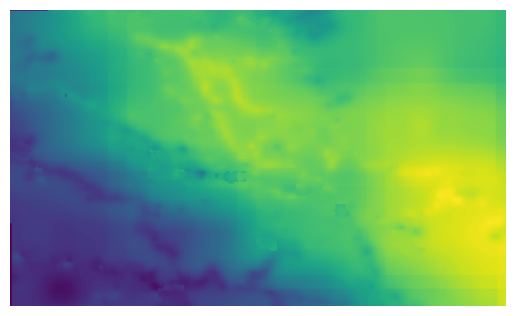

In [ ]:
with rasterio.open(fname_raster) as src:
    plt.axis('off')
    plt.imshow(src.read(1))

Let's start with a single area as an example:

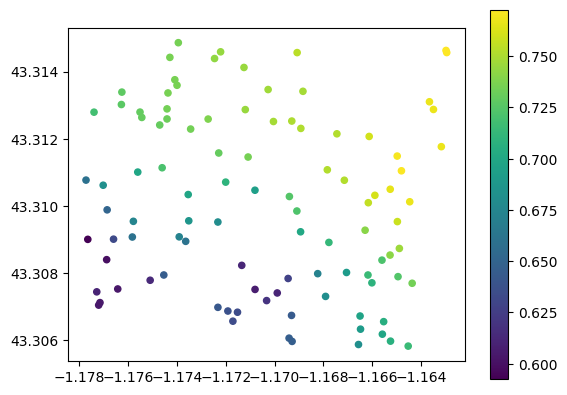

In [ ]:
sampler = Sampler(fname_raster)
gdf_samples = sampler.sample(sampling_locs)
gdf_samples.plot(column='value', s=20, legend=True);

In [ ]:
gdf_samples.head()

,loc_id,geometry,value
0,35,POINT (-1.17772 43.31077),0.659577
1,35,POINT (-1.17765 43.30900),0.592433
2,35,POINT (-1.17739 43.31279),0.718280
3,35,POINT (-1.17728 43.30744),0.609878
4,35,POINT (-1.17720 43.30704),0.603759


Than for all areas iteratively:

In [ ]:
sampler = Sampler(fname_raster)
n_planned = np.random.randint(1, high=10, size=len(gdf_grid), dtype=int)
loc_ids = gdf_grid.loc_id.values

samples_t0 = []
for loc_id, n in zip(loc_ids, n_planned):    
    sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n)
    gdf_samples = sampler.sample(sampling_locs)
    samples_t0.append(gdf_samples)

gdf_samples_t0 = pd.concat(samples_t0)

In [ ]:
gdf_samples_t0.head()

,loc_id,geometry,value
0,0,POINT (-1.22229 43.26640),0.135406
1,0,POINT (-1.22135 43.26756),0.131327
2,0,POINT (-1.21759 43.26384),0.134404
3,0,POINT (-1.21615 43.26210),0.130683
4,0,POINT (-1.21577 43.26287),0.126078


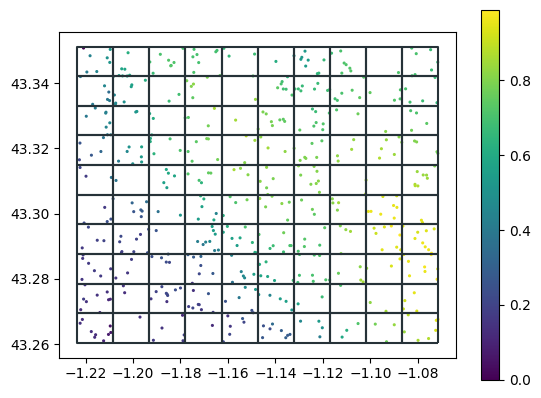

In [ ]:
ax = gdf_samples_t0.plot(column='value', s=1.5, legend=True)
gdf_grid.boundary.plot(color=black, ax=ax);

### Getting current state

In [ ]:
state = State(gdf_samples_t0, [MaxCB(), MinCB(), StdCB(), 
                               CountCB(), MoranICB(k=5), 
                               PriorCB(gdf_grid, fname_raster)])

In [ ]:
state.get(loc_id=1, as_numpy=True)

(array(['Max', 'Min', 'Standard Deviation', 'Count', 'Moran.I',
        'Moran_p_sim', 'Prior'], dtype='<U18'),
 array([1.80136591e-01, 1.10120580e-01, 2.16825660e-02, 9.00000000e+00,
        6.76835405e-01, 1.00000000e-03, 1.25727132e-01]))

## Build the ranking of polygons based on several criteria

### Criteria
- MaxCB()
- MinCB()
- StdCB()
- CountCB()
- MoranICB(k=5)
- PriorCB

### Criteria type 
- Benefit (high values --> high score --> rank high --> prioritized sampling needed)
- Cost (high values --> low score --> low high --> Less sampling needed)

- MaxCB() -- Benefit
- MinCB() -- ???
- StdCB() -- Benefit
- CountCB() -- Cost (Low count -- higher priority because more samples need)
- MoranICB(k=5) -- Cost (high value -- highly correlated -- less need for sampling ?? )
- PriorCB -- Benefit

### MCDM techniques
- CP -- low values -- good alternative
- TOPSIS -- High Value -- good alternative


In [ ]:
state = State(gdf_samples_t0, [StdCB(), CountCB(), PriorCB(gdf_grid, fname_raster)])
optimizer = Optimizer(state = state)
matrix = optimizer.build_matrix(polygon_list = gdf_samples_t0.loc_id.unique())

ranking = optimizer.rank(
        x_matrix = matrix,
        alt_names=None,
        is_benefit_x=[True, False, True],
        n_method="linear1",
        w_vector=[0.1, 0.8, 0.1],
        c_method=None,
        w_method=None,
        s_method="TOPSIS",
    )

ranking_dict = {}
for alt in ranking:
    ranking_dict[int(alt[0])] = int(alt[2])
    
gdf_samples_t0["ranking"] = gdf_samples_t0.loc_id.map(ranking_dict)

# Todo Loc_id 0 gives a Nan result (verify)
gdf_samples_t0.head()

,loc_id,geometry,value,ranking
0,0,POINT (-1.22229 43.26640),0.135406,NaN
1,0,POINT (-1.22135 43.26756),0.131327,NaN
2,0,POINT (-1.21759 43.26384),0.134404,NaN
3,0,POINT (-1.21615 43.26210),0.130683,NaN
4,0,POINT (-1.21577 43.26287),0.126078,NaN


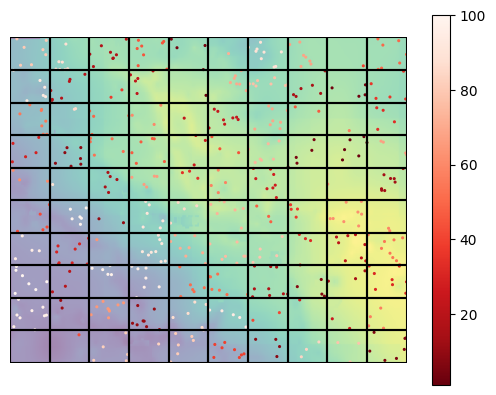

In [ ]:
import matplotlib.pyplot as plt
import rasterio

# Assuming fname_raster, gdf_samples_t0, and gdf_grid are already defined

# Open the raster file
with rasterio.open(fname_raster) as src:
    # Get the bounds of the raster
    bounds = src.bounds
    # Read the first band
    raster_data = src.read(1)
    # Calculate the extent of the raster image
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Create a plot
fig, ax = plt.subplots()

# Display the raster image with the correct extent
plt.imshow(raster_data, extent=extent, cmap='viridis', alpha=0.5)  # Adjust alpha for transparency

# Plot the geodataframes on top of the raster image
gdf_samples_t0.plot(column='ranking', s=1.5, legend=True, colormap='Reds_r', ax=ax)
gdf_grid.boundary.plot(color='black', ax=ax)

plt.axis('off')  # Hide axis
plt.show()